In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import entropy
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error, precision_recall_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import CalibrationError

from models.wide_resnet import Wide_ResNet
from multi_output_module.multi_output_module import Multi_output_module

In [16]:
class RandomSeverityAugMix:
    def __init__(self, min_severity=1, max_severity=5, prob=0.7, mixture_width=3, chain_depth=-1, alpha=1.0, all_ops=True, interpolation=InterpolationMode.BILINEAR, fill=None):
        self.min_severity = min_severity
        self.max_severity = max_severity
        self.prob = prob  # Probability of applying AugMix
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth
        self.alpha = alpha
        self.all_ops = all_ops
        self.interpolation = interpolation
        self.fill = fill

    def __call__(self, img):
        # Randomly decide whether to apply AugMix based on the probability
        if random.random() < self.prob:
            # If chosen to apply AugMix, randomly choose severity
            severity = random.randint(self.min_severity, self.max_severity)
            
            # Apply AugMix transformation
            augmix_transform = transforms.AugMix(
                severity=severity,
                mixture_width=self.mixture_width,
                chain_depth=self.chain_depth,
                alpha=self.alpha,
                all_ops=self.all_ops,
                interpolation=self.interpolation,
                fill=self.fill
            )
            
            # Apply the AugMix transformation to the image
            img = augmix_transform(img)
        
        # If not applying AugMix, return the original image
        return img

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path = '/home/natcgx/Single-pass UQ research project/data'
batch_size = 32
num_classes = 10

# Define the transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
'''
val_transform_cifar10 = transforms.Compose([
    RandomSeverityAugMix(min_severity=1, max_severity=10, prob=0.8),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
'''
# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=False, transform=transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

#train_dataset.transform = val_transform_cifar10
#val_dataset.dataset.transform = val_transform_cifar10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the transformations for the FashionMNIST dataset, converting grayscale to RGB
transform_fashion = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel RGB
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing for RGB
])

fashion_ood_dataset = torchvision.datasets.FashionMNIST(root=data_path, train=False, download=True, transform=transform_fashion)

fashion_ood_loader = DataLoader(fashion_ood_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the transformations for the CIFAR-100 dataset
transform_cifar100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

cifar100_ood_dataset = torchvision.datasets.CIFAR100(root=data_path, train=False, download=True, transform=transform_cifar100)

cifar100_ood_loader = DataLoader(cifar100_ood_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
base_model = Wide_ResNet(depth=28, widen_factor=10, dropout_rate=0.3, num_classes=num_classes)
base_model.load_state_dict(torch.load('./models/saved_models/cifar/cifar10/wide-resnet-28x10.pth'))
base_model = base_model.to(device)

In [19]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

accuracy = test(base_model, device, test_loader)
print(f'Reloaded model test accuracy: {accuracy:.2f}%')

Test set: Average loss: 0.1574, Accuracy: 9634/10000 (96.34%)

Reloaded model test accuracy: 96.34%


In [20]:
num_heads = 20
batch_size = 16
num_classes = 10

In [21]:
base_model.eval()

module = Multi_output_module(num_heads, base_model, device).to(device)
print(module)

optimizer = optim.Adam(module.parameters(), lr=0.0001, weight_decay=0.0005)

criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = num_heads * batch_size,
    shuffle=True,
    drop_last=True,
)

Multi_output_module(
  (activation): ReLU()
  (base_model): WideResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1): NetworkBlock(
      (layer): Sequential(
        (0): BasicBlock(
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BasicBlock(
          (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(160,

In [22]:
total_params = sum(p.numel() for p in module.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 36687794


In [ ]:
# Early stopping parameters
patience = 5
best_loss = float('inf')
epochs_no_improve = 0
num_epochs = 200  # Set a high number of epochs

#optimizer = optim.Adam(module.parameters(), lr=0.00001, weight_decay=0)

step = 0
for epoch in range(num_epochs):
    module.train()

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        step += 1

        #step = batch_idx + len(train_loader)*epoch+1

  
        # Ensure labels are correctly shaped
        labels = labels.view(-1, num_heads)

        optimizer.zero_grad()
        predictions = module(images, 'training')

        # Compute loss for each output head and sum them
        total_loss = 0
        for i in range(num_heads):
            total_loss += criterion(predictions[:, i, :], labels[:, i])
        total_loss /= num_heads
        
        total_loss.backward()
        optimizer.step()

        loss = total_loss.item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss:.6f}")

    module.eval()
    val_loss = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            predictions = module(images, 'inference')
            
            mimo_output_avg = predictions.mean(dim=1)
            val_loss += criterion(mimo_output_avg, labels).item()
            _, predicted = torch.max(mimo_output_avg, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / total
    print(f'Epoch {epoch}, Val Loss: {val_loss:.6f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)')

    '''
    wandb.log({
        "Iter step": step,
        "valid/accs": accuracy,
        #"test/accs": test_accs_b,
        #"valid/best_acc": self.best_valid_acc_b,
        #"test/best_acc": self.best_test_acc_b,
    })
    '''

    # Check for early stopping based on test loss
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        best_model_state = module.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

module.load_state_dict(best_model_state)

#wandb_switch('Multi output module', 'First run', 0, 'finish')

Train Epoch: 0 [0/45000 (0%)]	Loss: 2.440709
Train Epoch: 0 [32000/45000 (71%)]	Loss: 2.280950
Epoch 0, Val Loss: 0.055950, Accuracy: 5000/5000 (100.00%)
Train Epoch: 1 [0/45000 (0%)]	Loss: 2.257169
Train Epoch: 1 [32000/45000 (71%)]	Loss: 2.168582
Epoch 1, Val Loss: 0.052576, Accuracy: 5000/5000 (100.00%)
Train Epoch: 2 [0/45000 (0%)]	Loss: 2.162543
Train Epoch: 2 [32000/45000 (71%)]	Loss: 2.029727
Epoch 2, Val Loss: 0.047037, Accuracy: 5000/5000 (100.00%)
Train Epoch: 3 [0/45000 (0%)]	Loss: 1.965515
Train Epoch: 3 [32000/45000 (71%)]	Loss: 1.848817
Epoch 3, Val Loss: 0.041499, Accuracy: 5000/5000 (100.00%)
Train Epoch: 4 [0/45000 (0%)]	Loss: 1.816037
Train Epoch: 4 [32000/45000 (71%)]	Loss: 1.681634
Epoch 4, Val Loss: 0.035895, Accuracy: 5000/5000 (100.00%)
Train Epoch: 5 [0/45000 (0%)]	Loss: 1.669050
Train Epoch: 5 [32000/45000 (71%)]	Loss: 1.507789
Epoch 5, Val Loss: 0.030446, Accuracy: 5000/5000 (100.00%)
Train Epoch: 6 [0/45000 (0%)]	Loss: 1.404009
Train Epoch: 6 [32000/45000 (71

<All keys matched successfully>

In [10]:
def test_multioutput_out_last(module, device, test_loader):
    module.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            predictions = module(images, 'inference')
            mimo_output_avg = predictions[:,-1,:]
            _, predicted = torch.max(mimo_output_avg, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100. * correct / total
    return accuracy

accuracy = test_multioutput_out_last(module, device, test_loader)
print(f'Reloaded model test accuracy: {accuracy:.2f}%')


Reloaded model test accuracy: 95.45%


CIFAR10 Train set:
Average Entropy for Base Model Outputs: 0.0045
Average Entropy for Multi Outputs: 0.0733
CIFAR10 Test set:
Average Entropy for Base Model Outputs: 0.0461
Average Entropy for Multi Outputs: 0.1544
FashionMNIST OOD set:
Average Entropy for Base Model Outputs: 0.7251
Average Entropy for Multi Outputs: 1.1572
CIFAR100 OOD set:
Average Entropy for Base Model Outputs: 0.4724
Average Entropy for Multi Outputs: 0.8114


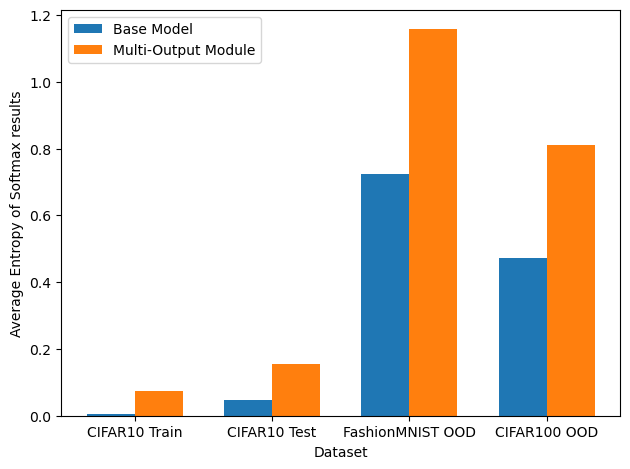

In [ ]:
# Function to compute and print the mean entropy of softmax outputs for base_model and module
def compute_mean_entropy_of_mean_softmax(loader, base_model, module, device):
    base_model.eval()
    module.eval()

    total_base_entropy_sum = 0
    total_multi_output_entropy_sum = 0
    num_samples = 0

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            batch_size = images.size(0)
            num_samples += batch_size

            # Base model prediction and entropy calculation
            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()
            base_entropies = np.sum(entropy(base_output_softmax, axis=1))
            total_base_entropy_sum += base_entropies

            # Repeat and reshape images for the multi-output module
            multi_output_predictions = module(images, 'inference')
            multi_output_avg = multi_output_predictions.mean(dim=1).cpu().numpy()
            multi_output_softmax = F.softmax(torch.tensor(multi_output_avg), dim=1).numpy()
            multi_output_entropy = np.sum(entropy(multi_output_softmax, axis=1))
            total_multi_output_entropy_sum += multi_output_entropy

    average_base_entropy = total_base_entropy_sum / num_samples
    average_multi_output_entropy = total_multi_output_entropy_sum / num_samples

    print(f"Average Entropy for Base Model Outputs: {average_base_entropy:.4f}")
    print(f"Average Entropy for Multi Outputs: {average_multi_output_entropy:.4f}")

    return average_base_entropy, average_multi_output_entropy


print("CIFAR10 Train set:")
train_base_entropy, train_multi_output_entropy = compute_mean_entropy_of_mean_softmax(train_loader, base_model, module, device)
print("CIFAR10 Test set:")
test_base_entropy, test_multi_output_entropy = compute_mean_entropy_of_mean_softmax(test_loader, base_model, module, device)
print("FashionMNIST OOD set:")
fashion_base_entropy, fashion_multi_output_entropy = compute_mean_entropy_of_mean_softmax(fashion_ood_loader, base_model, module, device)
print("CIFAR100 OOD set:")
cifar100_base_entropy, cifar100_multi_output_entropy = compute_mean_entropy_of_mean_softmax(cifar100_ood_loader, base_model, module, device)

labels = ['CIFAR10 Train', 'CIFAR10 Test', 'FashionMNIST OOD', 'CIFAR100 OOD']
base_entropies = [train_base_entropy, test_base_entropy, fashion_base_entropy, cifar100_base_entropy]
multi_output_entropies = [train_multi_output_entropy, test_multi_output_entropy, fashion_multi_output_entropy, cifar100_multi_output_entropy]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, base_entropies, width, label='Base Model')
rects2 = ax.bar(x + width/2, multi_output_entropies, width, label='Multi-Output Module')

ax.set_xlabel('Dataset')
ax.set_ylabel('Average Entropy of Softmax results')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
def compute_mce(predictions, confidences, labels, n_bins=15):
    """
    Compute Maximum Calibration Error (MCE).
    
    Parameters:
    - predictions (list or np.array): Model's predicted labels.
    - confidences (list or np.array): Model's confidence scores.
    - labels (list or np.array): True labels.
    - n_bins (int): Number of bins to compute calibration error.
    
    Returns:
    - mce (float): Maximum Calibration Error.
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    mce = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        if np.any(in_bin):
            accuracy_in_bin = np.mean(predictions[in_bin] == labels[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            mce = max(mce, np.abs(avg_confidence_in_bin - accuracy_in_bin))
    
    return mce

def compute_calibration_metrics(loader, base_model, module, device, num_classes=10):
    """
    Compute accuracy and calibration metrics for both base model and multi-output module.
    
    Parameters:
    - loader (DataLoader): Test data loader.
    - base_model (nn.Module): Base neural network model.
    - module (nn.Module): Multi-output module for calibration.
    - device (torch.device): Device to perform computations on.
    - num_classes (int): Number of output classes.
    
    Returns:
    - dict: Dictionary containing accuracy and calibration metrics for both models.
    """
    base_model.eval()
    module.eval()

    base_ece_metric = CalibrationError(n_bins=15, task="multiclass", num_classes=num_classes).to(device)
    multi_output_ece_metric = CalibrationError(n_bins=15, task="multiclass", num_classes=num_classes).to(device)

    base_all_labels, base_all_confidences, base_all_predictions = [], [], []
    multi_output_all_labels, multi_output_all_confidences, multi_output_all_predictions = [], [], []

    base_correct, base_total, base_test_loss = 0, 0, 0.0
    multi_output_correct, multi_output_total, multi_output_test_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            base_outputs = base_model(images)
            base_test_loss += F.cross_entropy(base_outputs, labels, reduction='sum').item()
            base_preds = base_outputs.argmax(dim=1)
            base_correct += base_preds.eq(labels).sum().item()
            base_total += labels.size(0)

            base_softmax_outputs = F.softmax(base_outputs, dim=1)
            base_ece_metric.update(base_softmax_outputs, labels)

            base_all_labels.extend(labels.cpu().numpy())
            base_all_confidences.extend(base_softmax_outputs.cpu().numpy())  # Store full softmax outputs
            base_all_predictions.extend(base_preds.cpu().numpy())

            multi_output_predictions = module(images, 'inference')
            multi_output_softmax = F.softmax(multi_output_predictions, dim=-1)
            multi_output_avg = multi_output_softmax.mean(dim=1)
            multi_output_test_loss += F.cross_entropy(multi_output_avg, labels, reduction='sum').item()
            multi_output_preds = multi_output_avg.argmax(dim=1)
            multi_output_correct += multi_output_preds.eq(labels).sum().item()
            multi_output_total += labels.size(0)

            multi_output_ece_metric.update(multi_output_avg, labels)

            multi_output_all_labels.extend(labels.cpu().numpy())
            multi_output_all_confidences.extend(multi_output_avg.cpu().numpy())
            multi_output_all_predictions.extend(multi_output_preds.cpu().numpy())

    base_all_confidences = np.array(base_all_confidences)  # Ensure this is 2D
    multi_output_all_confidences = np.array(multi_output_all_confidences)  # Ensure this is 2D

    base_accuracy = 100. * base_correct / base_total
    base_test_loss /= base_total
    base_ece = base_ece_metric.compute().item()

    base_nll = log_loss(base_all_labels, base_all_confidences, labels=np.arange(num_classes))
    base_brier = mean_squared_error(F.one_hot(torch.tensor(base_all_labels), num_classes=num_classes).numpy(), base_all_confidences)
    base_mce = compute_mce(np.array(base_all_predictions), base_all_confidences.max(axis=1), np.array(base_all_labels))

    multi_output_accuracy = 100. * multi_output_correct / multi_output_total
    multi_output_test_loss /= multi_output_total
    multi_output_ece = multi_output_ece_metric.compute().item()

    multi_output_nll = log_loss(multi_output_all_labels, multi_output_all_confidences, labels=np.arange(num_classes))
    multi_output_brier = mean_squared_error(F.one_hot(torch.tensor(multi_output_all_labels), num_classes=num_classes).numpy(), multi_output_all_confidences)
    multi_output_mce = compute_mce(np.array(multi_output_all_predictions), multi_output_all_confidences.max(axis=1), np.array(multi_output_all_labels))

    print(f"Base Model Accuracy: {base_accuracy:.2f}%, Brier Score: {base_brier:.4f}, NLL: {base_nll:.4f}, ECE: {base_ece:.4f}, MCE: {base_mce:.4f}")
    print(f"Multi-Output Module Accuracy: {multi_output_accuracy:.2f}%, Brier Score: {multi_output_brier:.4f}, NLL: {multi_output_nll:.4f}, ECE: {multi_output_ece:.4f}, MCE: {multi_output_mce:.4f}")

    return {
        "Base Model": {
            "Test NLL": base_nll,
            "Test Accuracy": base_accuracy,
            "Test Cal. Error": base_ece,
            "Test Brier Score": base_brier,
            "Test MCE": base_mce,
        },
        "Multi-Output Module": {
            "Test NLL": multi_output_nll,
            "Test Accuracy": multi_output_accuracy,
            "Test Cal. Error": multi_output_ece,
            "Test Brier Score": multi_output_brier,
            "Test MCE": multi_output_mce,
        }
    }

accuracy_metrics = compute_calibration_metrics(test_loader, base_model, module, device, num_classes)

Base Model Accuracy: 96.34%, Brier Score: 0.0061, NLL: 0.1574, ECE: 0.0233, MCE: 0.2711
Multi-Output Module Accuracy: 96.29%, Brier Score: 0.0058, NLL: 0.1429, ECE: 0.0179, MCE: 0.2576


In [ ]:
class TemperatureScaling(nn.Module):
    def __init__(self, base_model):
        """
        Wrap the base model to apply temperature scaling.
        """
        super(TemperatureScaling, self).__init__()
        self.base_model = base_model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)  # Initialize temperature to 1.5

    def forward(self, inputs):
        """
        Forward pass with temperature scaling applied to logits.
        """
        inputs = inputs.to(next(self.base_model.parameters()).device)
        logits = self.base_model(inputs)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Scale the logits using the learned temperature.
        """
        return logits / self.temperature.to(logits.device)

    def set_temperature(self, validation_loader, device):
        """
        Tune the temperature using validation data by minimizing NLL.
        """
        self.to(device)
        self.base_model.eval()
        nll_criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def closure():
            optimizer.zero_grad()
            nll_loss = 0.0
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = self.base_model(inputs)
                loss = nll_criterion(self.temperature_scale(logits), labels)
                nll_loss += loss.item()
            nll_loss /= len(validation_loader)
            loss.backward()
            return loss

        optimizer.step(closure)
        print(f"Optimal temperature: {self.temperature.item()}")

def compute_calibration(test_loader, model, device, n_bins=15):
    """
    Compute the Expected Calibration Error (ECE) for a given model and test_loader.
    """
    model.eval()
    model = model.to(device)
    ece = 0.0

    bin_boundaries = torch.linspace(0, 1, n_bins + 1).to(device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences_all = []
    predictions_all = []
    labels_all = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            probabilities = torch.softmax(logits, dim=1)
            confidences, predictions = probabilities.max(dim=1)

            confidences_all.append(confidences)
            predictions_all.append(predictions)
            labels_all.append(labels)

    confidences_all = torch.cat(confidences_all)
    predictions_all = torch.cat(predictions_all)
    labels_all = torch.cat(labels_all)
    correct = predictions_all.eq(labels_all)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences_all > bin_lower) & (confidences_all <= bin_upper)
        prop_in_bin = in_bin.float().mean().item()
        if prop_in_bin > 0:
            accuracy_in_bin = correct[in_bin].float().mean().item()
            avg_confidence_in_bin = confidences_all[in_bin].mean().item()
            ece += prop_in_bin * abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

base_model = base_model.to(device)

scaled_model = TemperatureScaling(base_model)
scaled_model.set_temperature(val_loader, device)

ece = compute_calibration(test_loader, base_model, device)
print(f'ECE before temp_scale: {ece}')
ece = compute_calibration(test_loader, scaled_model, device)
print(f'ECE after temp_scale: {ece}')

Optimal temperature: 1.377580165863037
ECE before temp_scale: 0.02722937172913664
ECE after temp_scale: 0.016536326851633615


In [ ]:
def compute_ood_detection_metrics(train_loader, ood_loader, base_model, module, num_classes, num_heads, device):
    base_model.eval()
    module.eval()

    base_ind_scores = []
    base_ood_scores = []
    multi_output_ind_scores = []
    multi_output_ood_scores = []

    with torch.no_grad():
        # Process In-Distribution (ID) data
        for images, _ in train_loader:
            images = images.to(device)

            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()
            base_entropy = entropy(base_output_softmax, axis=1)
            base_ind_scores.extend(base_entropy)

            multi_output_module_output = module(images, 'inference')
            multi_output_avg = multi_output_module_output.mean(dim=1)
            multi_output_softmax = F.softmax(multi_output_avg, dim=1).cpu().numpy()
            multi_output_entropy = entropy(multi_output_softmax, axis=1)
            multi_output_ind_scores.extend(multi_output_entropy)

        # Process Out-of-Distribution (OOD) data
        for images, _ in ood_loader:
            images = images.to(device)

            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()
            base_entropy = entropy(base_output_softmax, axis=1)
            base_ood_scores.extend(base_entropy)

            multi_output_module_output = module(images, 'inference')
            multi_output_avg = multi_output_module_output.mean(dim=1)
            multi_output_softmax = F.softmax(multi_output_avg, dim=1).cpu().numpy()
            multi_output_entropy = entropy(multi_output_softmax, axis=1)
            multi_output_ood_scores.extend(multi_output_entropy)

    # Generating labels (0 for in-distribution, 1 for OOD)
    base_labels = np.concatenate([np.zeros(len(base_ind_scores)), np.ones(len(base_ood_scores))])
    base_scores = np.concatenate([base_ind_scores, base_ood_scores])
    base_auroc = roc_auc_score(base_labels, base_scores)

    multi_output_labels = np.concatenate([np.zeros(len(multi_output_ind_scores)), np.ones(len(multi_output_ood_scores))])
    multi_output_scores = np.concatenate([multi_output_ind_scores, multi_output_ood_scores])
    multi_output_auroc = roc_auc_score(multi_output_labels, multi_output_scores)

    # Compute Area Under Recall (AUR)
    base_precision, base_recall, _ = precision_recall_curve(base_labels, base_scores)
    base_aur = np.trapz(base_recall, base_precision)  # AUR for base model

    multi_output_precision, multi_output_recall, _ = precision_recall_curve(multi_output_labels, multi_output_scores)
    multi_output_aur = np.trapz(multi_output_recall, multi_output_precision)  # AUR for multi-output model

    print(f"Base Model AUROC: {base_auroc:.4f}")
    print(f"Multi-Output Model AUROC: {multi_output_auroc:.4f}")
    print(f"Base Model AUR: {base_aur:.4f}")
    print(f"Multi-Output Model AUR: {multi_output_aur:.4f}")

    return {
        "base_auroc": base_auroc,
        "multi_output_auroc": multi_output_auroc,
        "base_aur": base_aur,
        "multi_output_aur": multi_output_aur,
    }

fashion_ood_metrics = compute_ood_detection_metrics(train_loader, fashion_ood_loader, base_model, module, num_classes, num_heads, device)
cifar100_ood_metrics = compute_ood_detection_metrics(train_loader, cifar100_ood_loader, base_model, module, num_classes, num_heads, device)

Base Model AUROC: 0.9925
Multi-Output Model AUROC: 0.9940
Base Model AUR: 0.7948
Multi-Output Model AUR: 0.7998
Base Model AUROC: 0.9609
Multi-Output Model AUROC: 0.9604
Base Model AUR: 0.7310
Multi-Output Model AUR: 0.7373
